# PATATO: A Python Photoacoustic Tomography Analysis Toolkit

In [3]:
%load_ext rpy2.ipython
import patato as pat
from patato.data import get_msot_time_series_example, get_msot_phantom_example
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [26]:
pa_so2 = get_msot_time_series_example("so2")
pa_dce = get_msot_time_series_example("icg") # We'll get the ROIs from here.
pa_so2.set_default_recon(("Reference Backprojection", "0"))
pa_dce.set_default_recon(("Reference Backprojection", "0"))
pa_dce.default_unmixing_type = "ICG"
pa_dce.external_roi_interface = pa_so2

# Get the oe reconstructions, so2 and delta icgs:
rec = pa_so2.get_scan_reconstructions()
so2 = pa_so2.get_scan_so2()
icg = pa_dce.get_scan_unmixed()[:, 2:] # ICG is the 3rd dataset in the unmixed data.

times = pa_so2.get_timestamps()[:, 0]
times -= times[0]
times /= 60

icg_times = pa_dce.get_timestamps()[:, 0]
icg_times -= icg_times[0]
icg_times /= 60

roi_tumour_right = pa_so2.get_rois()["tumour_right", "0"]
roi_tumour_left = pa_so2.get_rois()["tumour_left", "0"]
roi_reference = pa_so2.get_rois()["reference_", "0"]

In [27]:
def get_trace(time_series_data, region, filter_bad=False):
    mask, _ = region.to_mask_slice(time_series_data)
    timeseries = time_series_data.raw_data.T[mask.T].T[:, 0, :]
    # Unmixed SO2 can be out of the interval [0, 1] when there is low SNR.
    if filter_bad:
        timeseries[(timeseries>1) | (timeseries<0)] = np.nan
    return np.nanmean(timeseries, axis=-1)

def get_pixel_values(delta_values, region, filter_bad=False):
    mask, _ = region.to_mask_slice(delta_values)
    delta = delta_values.raw_data.T[mask.T].T

    if filter_bad:
        delta[(delta>0.1) | (delta<-0.1)] = np.nan
    return delta

gca = pat.GasChallengeAnalyser(display_output=False)
dso2, _, (baseline_so2, baseline_sigma_so2) = gca.run(so2, pa_so2)

dce = pat.DCEAnalyser(display_output=False)
dicg, _, [baseline_icg, baseline_sigma_icg] = dce.run(pa_dce.get_scan_unmixed(), pa_dce)

In [28]:
pa_so2.get_wavelengths()

array([700., 730., 750., 760., 770., 800., 820., 840., 850., 880.])

In [29]:
icg_df = pd.DataFrame({"times": np.concatenate([icg_times] * 3), 
                       "ICG": np.concatenate([get_trace(icg, r) for r in [roi_reference, roi_tumour_right, roi_tumour_left]]),
                       "Region": ["Spine"] * len(icg_times) + ["Right Tumour"] * len(icg_times) + ["Left Tumour"] * len(icg_times)
                      })


so2_df = pd.DataFrame({"times": np.concatenate([times] * 3), 
                       "SO2": np.concatenate([get_trace(so2, r, True) for r in [roi_reference, roi_tumour_right, roi_tumour_left]]),
                       "Region": ["Spine"] * len(times) + ["Right Tumour"] * len(times) + ["Left Tumour"] * len(times)
                      })

im_recon = rec.imshow()
im_dso2 = dso2.imshow(roi_mask=[roi_reference, roi_tumour_right, roi_tumour_left])
im_dicg = dicg.imshow(roi_mask=[roi_reference, roi_tumour_right, roi_tumour_left])
plt.close()

In [30]:
dso2_array = im_dso2.get_array().data
iqr = np.nanpercentile(dso2_array, 75) - np.nanpercentile(dso2_array, 25)
med = np.nanmedian(dso2_array)
dso2_array[dso2_array > med + 3 * iqr] = np.nan
dso2_array[dso2_array < med - 3 * iqr] = np.nan

dicg_array = im_dicg.get_array().data
iqr = np.nanpercentile(dicg_array, 75) - np.nanpercentile(dicg_array, 25)
med = np.nanmedian(dicg_array)
dicg_array[dicg_array > med + 6 * iqr] = np.nan
dicg_array[dicg_array < med - 6 * iqr] = np.nan

rec_array = im_recon.get_array().data

In [31]:
dicgs = [get_pixel_values(dicg, r) for r in [roi_reference, roi_tumour_right, roi_tumour_left]]
dso2s = [get_pixel_values(dso2, r, True) for r in [roi_reference, roi_tumour_right, roi_tumour_left]]

compare_df = pd.DataFrame({"dicg": np.concatenate(dicgs), 
                           "dso2": np.concatenate(dso2s),
                           "Region": sum([[s] * len(j) for s, j in zip(["Reference", "Right Tumour", "Left Tumour"], dso2s)], start=[])
                      })

compare_df

,dicg,dso2,Region
0,0.311121,0.064291,Reference
1,0.342048,0.069366,Reference
2,0.303935,0.058339,Reference
3,0.379399,0.083608,Reference
4,0.415269,0.086471,Reference
...,...,...,...
1950,0.248291,0.063927,Left Tumour
1951,0.159100,0.036841,Left Tumour
1952,0.190295,0.041764,Left Tumour
1953,0.216423,0.050411,Left Tumour


--- Please select a CRAN mirror for use in this session ---
Secure CRAN mirrors 

 1: 0-Cloud [https]
 2: Australia (Canberra) [https]
 3: Australia (Melbourne 1) [https]
 4: Australia (Melbourne 2) [https]
 5: Australia (Perth) [https]
 6: Austria [https]
 7: Belgium (Brussels) [https]
 8: Brazil (PR) [https]
 9: Brazil (RJ) [https]
10: Brazil (SP 1) [https]
11: Brazil (SP 2) [https]
12: Bulgaria [https]
13: Canada (MB) [https]
14: Canada (ON 3) [https]
15: Chile (Santiago) [https]
16: China (Beijing 2) [https]
17: China (Beijing 3) [https]
18: China (Hefei) [https]
19: China (Hong Kong) [https]
20: China (Guangzhou) [https]
21: China (Jinan) [https]
22: China (Lanzhou) [https]
23: China (Nanjing) [https]
24: China (Shanghai 2) [https]
25: China (Shenzhen) [https]
26: Colombia (Cali) [https]
27: Costa Rica [https]
28: Cyprus [https]
29: Czech Republic [https]
30: Denmark [https]
31: East Asia [https]
32: Ecuador (Cuenca) [https]
33: France (Lyon 1) [https]
34: France (Lyon 2) [https]


Selection:  70



The downloaded binary packages are in
	/var/folders/v4/tlcsrfts401cwf12yj4znlxw8cj3p3/T//RtmpqyA00b/downloaded_packages


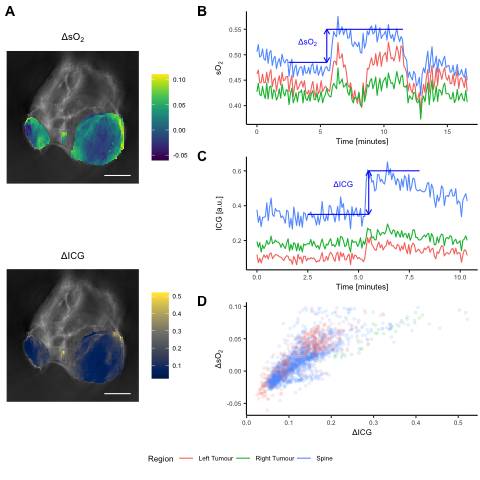

In [33]:
%%R -i dso2_array -i rec_array -i dicg_array -i icg_df -i so2_df -i compare_df

library(tidyverse)
library(viridis)
library(ggnewscale)
library(ggplot2)
library(cowplot)
library(hexbin)

make_image_df <- function(image, x_min, x_max, y_min, y_max, name="data") {
    m_df <- image %>%
      as.data.frame() %>%
      rowid_to_column(var = 'y') %>%
      pivot_longer(-y, names_to = "x", values_to = name) %>%
      mutate(x = parse_number(x))
    m_df$y <- max(m_df$y) - m_df$y
    m_df$y <- m_df$y / max(m_df$y) * (y_max - y_min) + y_min
    m_df$x <- m_df$x / max(m_df$x) * (x_max - x_min) + x_min
    return (m_df)
}

dso2_df <- make_image_df(dso2_array, -0.0125, 0.0125, -0.0125, 0.0125)
dicg_df <- make_image_df(dicg_array, -0.0125, 0.0125, -0.0125, 0.0125)
im_df <- make_image_df(rec_array, -0.0125, 0.0125, -0.0125, 0.0125)

im_df$data = im_df$data/1e5

theme_update(text=element_text(size=8))

scalebarwidth = 5
scale_x = 0.011
scale_y = -scale_x

# Plot the images.
fig_a = ggplot(im_df, aes(x=x, y=y, fill=data)) + geom_raster() + 
    scale_fill_gradient("PA Signal", low = "#000000",high = "#FFFFFF", guide=FALSE) + new_scale_fill() + 
    geom_raster(data=dso2_df, aes(x=x, y=y, fill =data)) +
    scale_fill_viridis(element_blank(), na.value = "transparent", guide=guide_colourbar(title.position = "right", barheight=6)) +
    coord_fixed() + theme_void() +
    ggtitle(expression(ΔsO[2])) + theme(legend.box="vertical", legend.direction="vertical", legend.position="right", legend.justification = c(0, 0.5), 
                                        plot.title=element_text(hjust = 0.5), text=element_text(size=8), plot.margin = unit(c(0., 0., 0., 0.), "null"), plot.background = element_rect(fill = "white", colour = NA_character_)) +
    annotate("segment", x = scale_x - scalebarwidth/1000, xend = scale_x, y = scale_y, yend=scale_y, colour = "white") # Scale bar <---

fig_b = ggplot(im_df, aes(x=x, y=y, fill=data)) + geom_raster() + 
    scale_fill_gradient("PA Signal", low = "#000000",high = "#FFFFFF", guide=FALSE) + new_scale_fill() + 
    geom_raster(data=dicg_df, aes(x=x, y=y, fill =data)) +
    scale_fill_viridis(element_blank(), na.value = "transparent", option="E", guide=guide_colourbar(title.position="right", barheight=6)) +
    coord_fixed() + theme_void() +
    ggtitle("ΔICG") + theme(legend.box="vertical", legend.direction="vertical", legend.position="right", legend.justification = c(0, 0.5), 
                            plot.title=element_text(hjust = 0.5), text=element_text(size=8), plot.margin = unit(c(0., 0., 0., 0.), "null"), plot.background = element_rect(fill = "white", colour = NA_character_))+
    annotate("segment", x = scale_x - scalebarwidth/1000, xend = scale_x, y = scale_y, yend=scale_y, colour = "white") # Scale bar <---

# Prepare the line plots.
fig_c <- ggplot(so2_df, aes(x = times, y = SO2, color = Region)) + geom_line() + theme_classic() + theme(legend.position="bottom") + xlab("Time [minutes]") + ylab(expression(sO[2]))+ theme(text = element_text(size = 8),plot.margin = unit(c(0.1, 0.01, 0., 0.1), "null"))  
fig_c <- fig_c + annotate("segment", x = 5.5, xend = 11.5, y = 0.55, yend = 0.55, colour = "blue") + 
            annotate("segment", x = 2.5, xend = 5.5, y = 0.485, yend=0.485, colour = "blue") +
            annotate("segment", x = 5.5, xend = 5.5, y = 0.485, yend=0.55, colour="blue", arrow= arrow(ends="both", length = unit(0.2, "cm"))) + 
            annotate("text", x=4, y=0.525, label = expression(ΔsO[2]), size = 8/.pt, colour="blue")

fig_d <- ggplot(icg_df, aes(x = times, y = ICG, color = Region)) + geom_line() + theme_classic() + 
            theme(legend.position="none") + xlab("Time [minutes]") + ylab("ICG [a.u.]")+ theme(text = element_text(size = 8),plot.margin = unit(c(0.1, 0.01, 0, 0.1), "null")) + 
            annotate("segment", x = 5.5, xend = 8, y = 0.6, yend = 0.6, colour = "blue") + 
            annotate("segment", x = 2.5, xend = 5.5, y = 0.35, yend=0.35, colour = "blue") +
            annotate("segment", x= 5.5, xend = 5.5, y = 0.35, yend=0.6, colour="blue", arrow= arrow(ends="both", length = unit(0.2, "cm"))) + 
            annotate("text", x=4.25, y=0.525, label ="ΔICG", size = 8/.pt, colour="blue")
            
fig_e <- ggplot(compare_df, aes(y = dso2, x=dicg, color=Region)) + geom_point(size=1, alpha=0.1) + 
        theme_classic() + theme(legend.position="none", text = element_text(size = 8),plot.margin = unit(c(0.1, 0.01, 0, 0.1), "null")) + ylab(expression(ΔsO[2])) + xlab("ΔICG")

# Manually sort out the legends.
fig_c_legend = get_legend(fig_c + theme(legend.box.margin=margin(0, 0, 0,0), legend.background=element_rect(fill = "transparent", colour = NA)))

fig_c <- fig_c + theme(legend.position = "none")

aligned_ab <- align_plots(fig_a, fig_b, align = "hv")

top_row <- plot_grid(aligned_ab[[1]], aligned_ab[[2]], nrow=2)

aligned_cd <- align_plots(fig_c, fig_d, fig_e, align = "hv")
bottom_row <- plot_grid(aligned_cd[[1]], aligned_cd[[2]], aligned_cd[[3]], nrow=3, ncol=1, labels=c('B', 'C', 'D'), x_label=0)

figure <- plot_grid(top_row, bottom_row, ncol = 2, labels = c('A', ''), rel_widths=c(1, 1.5)) + theme(plot.background = element_rect(fill = "white", colour = NA))

figure <- plot_grid(figure, fig_c_legend, nrow=2, rel_heights=c(10, 1)) + theme(plot.background = element_rect(fill = "white", colour = NA))
ggsave2("dce_oe_plot.png", plot=figure, width=13.5, height=8.8, unit="cm")
install.packages("svglite")
ggsave2("dce_oe_plot.svg", plot=figure, width=13.5, height=8.8, unit="cm")
print(figure)

In [39]:
# Phantom figure:
import matplotlib
matplotlib.rc('font', family='Arial') 

p_clinical = get_msot_phantom_example("clinical")[4:5]
p_clinical.set_default_recon()
p_preclinical = get_msot_phantom_example("preclinical")
p_preclinical.set_default_recon()

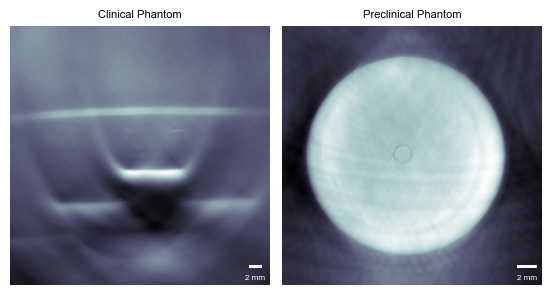

In [71]:
inch = 2.54
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13.5 / inch, 7.5 / inch))
r = p_clinical.get_scan_reconstructions()
ax1.set_title("Clinical Phantom", fontsize=8)
r.imshow(ax=ax1)

r = p_preclinical.get_scan_reconstructions()[:, 30:31]
ax2.set_title("Preclinical Phantom", fontsize=8)
r.imshow(ax=ax2)
fig.subplots_adjust(left=0, right=1, bottom=0, hspace=0.005, wspace=0.05)
plt.savefig("test_figure.pdf")
plt.savefig("test_figure.png", dpi=300)
plt.show()

In [15]:
p_preclinical.get_scan_datetime()

datetime.datetime(2021, 9, 2, 15, 39, 27, 814586)